In [1]:
import sys
import time
sys.path.append('/home/kevinteng/Desktop/BrainTumourSegmentation')
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import os, random
import utils
from utils_vis import plot_comparison, plot_labels_color, plot_loss
from utils import compute_metric_dc, data_aug
import nibabel as nib
from sklearn.model_selection import KFold
from loss_fn import *
%matplotlib inline

- Blue => Label 1 (Necrotic and Non-enhancing Tumor Core)
- Yellow => Label 2 (Peritumoral Edema)
- Green => Label 3/4 (GD-Enhancing Tumor)
---
* Core => Label 1 & 3
* Enhancing => Label 3
* Complete => Label 1,2, 3

---

# Hyperparameter

In [2]:
SHUFFLE_BUFFER = 4000
BATCH_SIZE = 8
lr = 0.00001
opt = tf.keras.optimizers.Adam(lr)
ver = 'model_vnet03' #save version
dropout=0.2 #dropout rate
hn = 'he_normal' #kernel initializer

---

# Helper Functions

---

----

# Model

In [3]:
from tensorflow.keras.layers import Conv3D, UpSampling3D, MaxPool3D, GaussianNoise
from tensorflow.keras.layers import Input, BatchNormalization, PReLU, ReLU, Dropout
from tensorflow.keras.layers import Add, Multiply, Activation
from tensorflow_addons.layers import GroupNormalization
from tensorflow.keras import Model

hn = 'he_normal' #kernel initializer

def conv_block_3D(x, filters, norm_fn='gn', kernel_size=3,
               kernel_initializer=hn, acti_fn='prelu', dropout_rate=None):
    '''
    Dual convolution block with [full pre-activation], Norm -> Acti -> Conv
    :param x: Input features
    :param filters: A list that contains the number of filters for 1st and 2nd convolutional layer
    :param norm_fn: Tensorflow function for normalization, 'bn' for Batch Norm, 'gn' for Group Norm
    :param kernel_size: Kernel size for both convolutional layer with 3x3 as default
    :param kernel_initializer: Initializer for kernel weights with 'glorot uniform' as default
    :param acti_fn: Tensorflow function for activation, 'relu' for ReLU, 'prelu' for PReLU
    :param dropout_rate: Specify dropouts for layers
    :return: Feature maps of same size as input with number of filters equivalent to the last layer
    '''
    assert type(filters)==list, "Please input filters of type list."
    assert acti_fn!= None, 'There should be an activation function specified'
    #1st convolutional block
    if norm_fn=='bn':
        x = BatchNormalization()(x)
    elif norm_fn=='gn':
        x = GroupNormalization()(x)
    if acti_fn=='relu':
        x = ReLU()(x)
    elif acti_fn=='prelu':
        x = PReLU(shared_axes=[1,2,3])(x)
    if dropout_rate != None:
        x = Dropout(dropout_rate)(x)
    x = Conv3D(filters[0], kernel_size, padding='same', kernel_initializer=kernel_initializer)(x)
    #2nd convolutional block
    if norm_fn=='bn':
        x = BatchNormalization()(x)
    elif norm_fn=='gn':
        x = GroupNormalization()(x)
    if acti_fn=='relu':
        x = ReLU()(x)
    elif acti_fn=='prelu':
        x = PReLU(shared_axes=[1,2,3])(x)
    x = Conv3D(filters[1], kernel_size, padding='same', kernel_initializer=kernel_initializer)(x)
    return x


def down_sampling_3D(x, filters, norm_fn='gn', kernel_size=3, acti_fn='relu',
            kernel_initializer=hn, dropout_rate=None):
    '''
    Down sampling function version 2 with Convolutional layer of stride 2 as downsampling operation, with
    [full pre-activation], Norm -> Acti -> Conv
    :param x: Input features
    :param filters: Number of filters for Convolutional layer of stride 2
    :param norm_fn: Tensorflow function for normalization, 'bn' for Batch Norm, 'gn' for Group Norm
    :param kernel_size: Kernel size for both convolutional layer with 3x3 as default
    :param acti_fn: Tensorflow function for activation, 'relu' for ReLU, 'prelu' for PReLU
    :param kernel_initializer: Initializer for kernel weights with 'glorot uniform' as default
    :param dropout_rate: Specify dropouts for layers
    :return: Feature maps of size scaled down by 2 with number of filters specified
    '''
    assert acti_fn!= None, 'There should be an activation function specified'
    #normalization
    if norm_fn=='bn':
        x = BatchNormalization()(x)
    elif norm_fn=='gn':
        x = GroupNormalization()(x)
    if acti_fn=='relu':
        x = ReLU()(x)
    #activation
    elif acti_fn=='prelu':
        x = PReLU(shared_axes=[1,2,3])(x)
    if dropout_rate != None:
        x = Dropout(dropout_rate)(x)
    #normal mode
    x = Conv3D(filters, kernel_size, strides=(2,2,2), padding='same', kernel_initializer=kernel_initializer)(x)
    return x


def res_block_3D(x_in, filters, norm_fn='gn', kernel_size=3,
               kernel_initializer=hn, acti_fn='prelu', dropout_rate=None):
    '''
    This function construct the residual block in 3D by input->conv_block_3D->concat([input,conv_output])
    :param x: Input features
    :param filters: A list that contains the number of filters for 1st and 2nd convolutional layer
    :param norm_fn: Tensorflow function for normalization, 'bn' for Batch Norm, 'gn' for Group Norm
    :param kernel_size: Kernel size for both convolutional layer with 3x3 as default
    :param kernel_initializer: Initializer for kernel weights with 'glorot uniform' as default
    :param acti_fn: Tensorflow function for activation, 'relu' for ReLU, 'prelu' for PReLU
    :param dropout_rate: Specify dropouts for layers
    :return: Resblock output => concatenating input with 2*convlutional output
    '''
    assert len(filters)==2, "Please assure that there is 2 values for filters."
    output_conv_block = conv_block_3D(x_in, filters, norm_fn=norm_fn, kernel_size=kernel_size,
                                   kernel_initializer = kernel_initializer, acti_fn = acti_fn, dropout_rate=dropout_rate)
    output_add = Add()([output_conv_block, x_in])
    return output_add


def up_3D(x_in, filters, merge, kernel_initializer=hn, size=(2, 2, 2)):
    '''
    This function carry out the operation of deconvolution => upsampling + convolution, and
    concatenating feture maps from the skip connection with the deconv feature maps
    @param x_in: input feature
    @param filters: Number of filters
    @param merge: featrure maps from the skip connection
    @param kernel_initializer: Initializer for kernel weights with 'glorot uniform' as default
    @param size: Upsampling size, by default (1,2,2)
    @return: concatenate feature maps of skip connection output and upsampled feature maps from previous output
    '''
    u = UpSampling3D(size)(x_in)
    conv = Conv3D(filters=filters, kernel_size=3, padding='same',
                  kernel_initializer=kernel_initializer)(u)
    conv = PReLU(shared_axes=[1,2,3])(conv)
    concat = tf.concat([merge, conv], axis=-1)
    return concat


def attention_block_3D(input_signal, gated_signal, filters, kernel_initializer=hn):
    # input signal feature maps
    is_fm = Conv3D(filters, kernel_size=1, strides=2, padding = 'same',
                   kernel_initializer=kernel_initializer)(input_signal)
    # gated signal feature maps
    gs_fm = Conv3D(filters, kernel_size=1, strides=1, padding = 'same',
                   kernel_initializer=kernel_initializer)(gated_signal)
    # debugger
    assert is_fm.shape!=gs_fm.shape, "Feature maps shape doesn't match!"
    # element wise sum
    add = Add()([is_fm, gs_fm])
    acti = Activation('relu')(add)
    # downsampled attention coefficient
    bottle_neck = Conv3D(1, kernel_size=1, activation='sigmoid',
                         kernel_initializer=kernel_initializer)(acti)
    # bilinear interpolation to get attention coeffcient
    alpha = UpSampling3D(size=2)(bottle_neck)
    # filter off input signal's features with attention coefficient
    multi = Multiply()([input_signal, alpha])
    return multi


def DeepAttVnet(x):
    #filter list
    f_list = [8, 16, 32, 64]
    # inject gaussian noise
    gauss1 = GaussianNoise(0.01)(x)
    # -----------down sampling path--------------------------------------
    # 1st block [155, 200, 200, 4]
    conv_01 = Conv3D(f_list[0], 3, padding='same', kernel_initializer=hn)(gauss1)
    conv_01 = PReLU(shared_axes=[1,2,3])(conv_01)
    res_block01 = conv_block_3D(conv_01, filters=[f_list[0]*2, f_list[0]])
    # 2nd block [155, 100, 100, 4]
    down_01 = down_sampling_3D(res_block01,filters=f_list[1])
    res_block02 = res_block_3D(down_01, filters=[f_list[1]*2, f_list[1]])
    # 3rd block [155, 50, 50, 4]
    down_02 = down_sampling_3D(res_block02,filters=f_list[2])
    res_block03 = res_block_3D(down_02, filters=[f_list[2]*2, f_list[2]])
    # 4th block [155, 25, 25, 4] *latent space
    down_03 = down_sampling_3D(res_block03,filters=f_list[3])
    res_block04 = res_block_3D(down_03, filters=[f_list[3]*2, f_list[3]])

    # -----------up sampling path-----------------------------------------
    # 1st attention block---
    att_01 = attention_block_3D(res_block03, res_block04, f_list[2])
    # 1st up [155, 50, 50, 4]
    up_01 = up_3D(res_block04, f_list[2], att_01)
    up_conv01 = conv_block_3D(up_01, filters=[f_list[2], f_list[2]])
    # 1st block segmentation output
    seg_01 = Conv3D(4, kernel_size=1, padding='same', kernel_initializer=hn)(up_conv01)

    # 2nd attention block---
    att_02 = attention_block_3D(res_block02, up_conv01, f_list[1])
    # 2nd up [155, 100, 100, 4]
    up_02 = up_3D(up_conv01, f_list[1], att_02)
    up_conv02 = conv_block_3D(up_02, filters=[f_list[1], f_list[1]])
    # 2nd block segmentation output
    seg_02 = Conv3D(4, kernel_size=1, padding='same', kernel_initializer=hn)(up_conv02)

    # 3rd attention block---
    att_03 = attention_block_3D(res_block01, up_conv02, f_list[0])
    # 3rd up [155, 200, 200, 4]
    up_03 = up_3D(up_conv02, f_list[0], att_03)
    up_conv03 = conv_block_3D(up_03, filters=[f_list[0], f_list[0]])
    # 3rd block segmentation output
    seg_03 = Conv3D(4, kernel_size=1, padding='same', kernel_initializer=hn)(up_conv03)

    # Deep Supervision---
    #Add all segmentation output before inputting into the output layer
    #upsample to fit the size of seg_02
    seg_01_up = UpSampling3D(size=2)(seg_01)
    add_0102 = Add()([seg_01_up,seg_02])
    #upsample to fit the size of seg_03
    add_0102_up = UpSampling3D(size=2)(add_0102)
    add_010203 = Add()([add_0102_up, seg_03])

    #segmentation output
    output = Conv3D(4,kernel_size=1, activation='softmax',
                    kernel_initializer=hn)(add_010203)
    return output

In [4]:
#Build Model
input_layer = Input(shape=(128,200,200,4))
model = Model(input_layer, DeepAttVnet(input_layer))

In [5]:
xent = tf.keras.losses.CategoricalCrossentropy()

@tf.function
def train_fn(image, label):
    with tf.GradientTape() as tape:
        model_output = model(image, training=True)
        loss, l_xent, l_dc  = custom_loss(label, model_output)
        l_list = [loss, l_xent, l_dc]
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))

    return model_output, l_list, gradients

---


Epochs  1



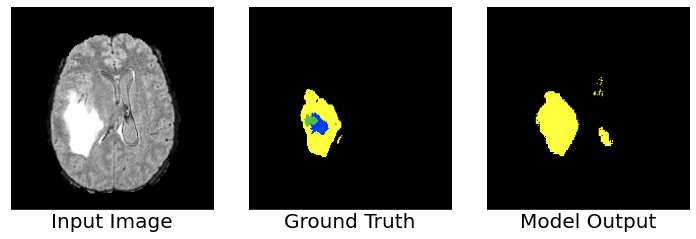

Steps: 300, L_xent: 0.1404074728488922, L_dc: 0.4731539487838745
Total loss: 0.6135613918304443
Accurary: 0.9813500046730042
Seq: TC, ET, WT
Dice coefficient: [0.9125, 0.935, 0.903154695580403]
Gradient min:-1.0626500844955444, max:0.7459014058113098
Compute time per epochs: 16.75 mins

Epochs  2



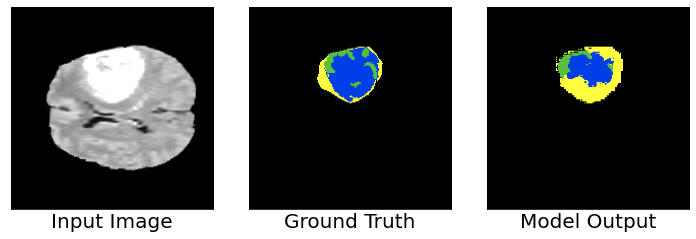

Steps: 300, L_xent: 0.05882386118173599, L_dc: 0.4147300124168396
Total loss: 0.473553866147995
Accurary: 0.9651749730110168
Seq: TC, ET, WT
Dice coefficient: [0.8658875175192953, 0.8751385150104761, 0.8497752807289362]
Gradient min:-0.3246840238571167, max:0.21488390862941742
Compute time per epochs: 16.37 mins

Epochs  3



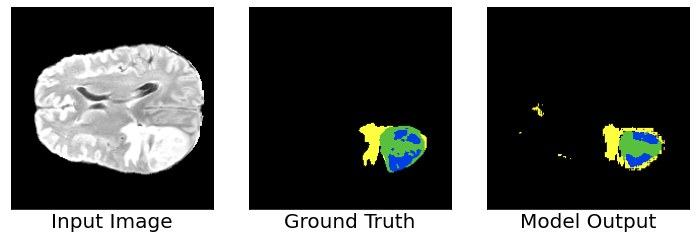

Steps: 300, L_xent: 0.03169936686754227, L_dc: 0.3095433712005615
Total loss: 0.3412427306175232
Accurary: 0.9775000214576721
Seq: TC, ET, WT
Dice coefficient: [0.8978526944667101, 0.8805642991513014, 0.8744162462403376]
Gradient min:-0.13476607203483582, max:0.10983329266309738
Compute time per epochs: 16.39 mins

Epochs  4



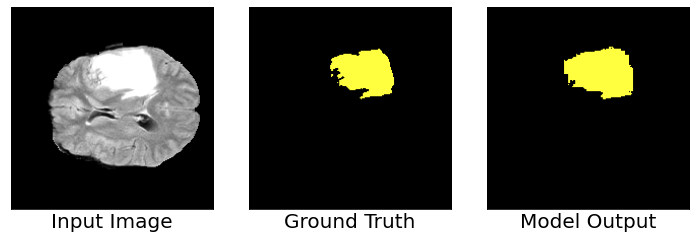

Steps: 300, L_xent: 0.025624146685004234, L_dc: 0.4100911021232605
Total loss: 0.4357152581214905
Accurary: 0.9880250096321106
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 0.9830458291371663]
Gradient min:-0.32743769884109497, max:0.7413811087608337
Compute time per epochs: 16.39 mins

Epochs  5



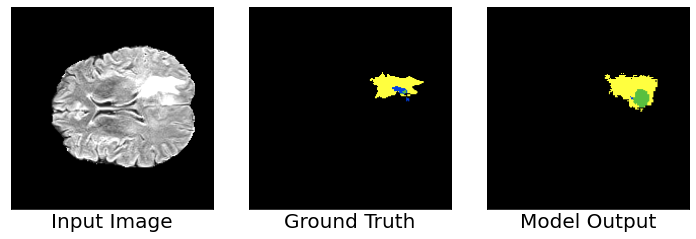

Steps: 300, L_xent: 0.031449925154447556, L_dc: 0.5003868937492371
Total loss: 0.5318368077278137
Accurary: 0.9855499863624573
Seq: TC, ET, WT
Dice coefficient: [0.9268333334475756, 0.9186666668951511, 0.9145936831956109]
Gradient min:-0.06009683385491371, max:0.1400771290063858
Compute time per epochs: 16.88 mins

Epochs  6



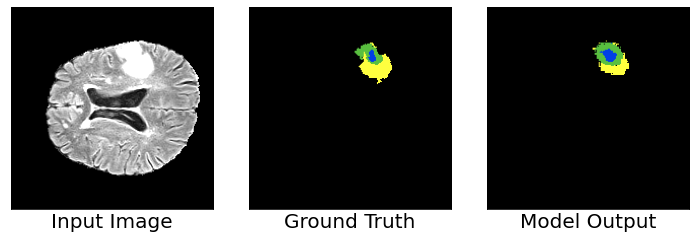

Steps: 300, L_xent: 0.009840568527579308, L_dc: 0.4959006905555725
Total loss: 0.5057412385940552
Accurary: 0.989674985408783
Seq: TC, ET, WT
Dice coefficient: [0.9603927906602621, 0.9507901139557362, 0.9301733602086703]
Gradient min:-0.5240864157676697, max:0.5142686367034912
Compute time per epochs: 16.36 mins

Epochs  7



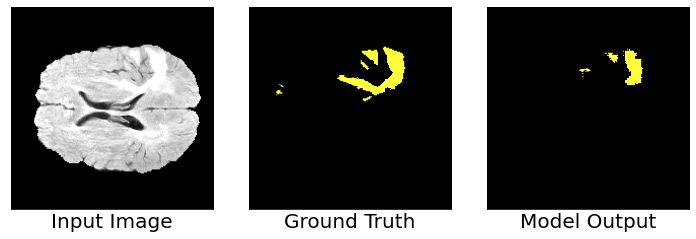

Steps: 300, L_xent: 0.03633293882012367, L_dc: 0.3980948328971863
Total loss: 0.43442776799201965
Accurary: 0.9822750091552734
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 0.9531781676039099]
Gradient min:-0.5495800971984863, max:1.2121069431304932
Compute time per epochs: 16.37 mins

Epochs  8



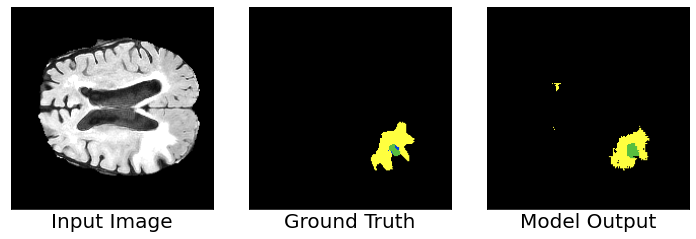

Steps: 300, L_xent: 0.010927332565188408, L_dc: 0.7538526058197021
Total loss: 0.7647799253463745
Accurary: 0.9896500110626221
Seq: TC, ET, WT
Dice coefficient: [0.9626364536583424, 0.9702729073166847, 0.9353131920595964]
Gradient min:-0.38238033652305603, max:0.3351137340068817
Compute time per epochs: 16.37 mins

Epochs  9



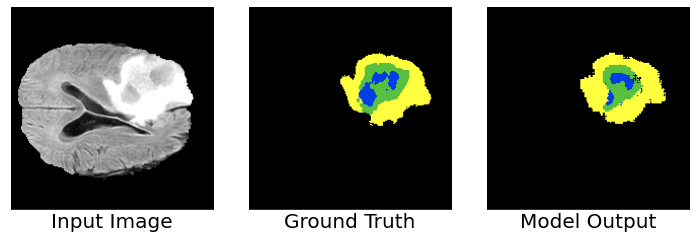

Steps: 300, L_xent: 0.06107790768146515, L_dc: 0.33860594034194946
Total loss: 0.3996838331222534
Accurary: 0.9715999960899353
Seq: TC, ET, WT
Dice coefficient: [0.9109837702475488, 0.907810099683702, 0.9139966231957078]
Gradient min:-0.2982865869998932, max:0.2775343954563141
Compute time per epochs: 16.38 mins

Epochs 10



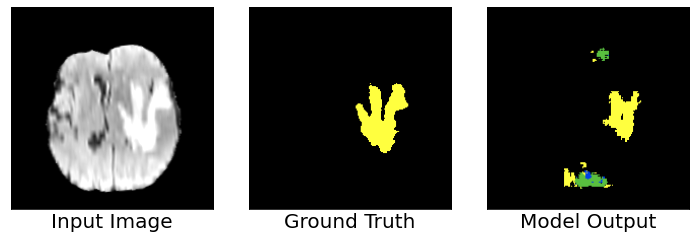

Steps: 300, L_xent: 0.12050524353981018, L_dc: 0.7939801812171936
Total loss: 0.9144854545593262
Accurary: 0.9579499959945679
Seq: TC, ET, WT
Dice coefficient: [0.895, 0.86, 0.8197792836030324]
Gradient min:-0.5828419327735901, max:0.47674205899238586
Compute time per epochs: 16.85 mins

----------------------------------<END>---------------------------------
Total run time for 10 epochs: 165.11 mins


In [6]:
#numpy dir
npy_dir = '/home/kevinteng/Desktop/ssd02/BraTS2020_preprocessed05/Training_pre/'
#
pre_epochs = 20
max_epochs = 30
#remainder epochs 
re_epochs = max_epochs - pre_epochs 
if pre_epochs!=0:
    model.load_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))
    upp_bound = re_epochs
else:
    upp_bound = max_epochs
    
epochs = 1
#list
loss_list = []
start_runtime = time.time()
while epochs <= upp_bound:
    start = time.time()
    print()
    print("Epochs {:2d}".format(epochs))
    steps = 1
    ds = os.listdir(npy_dir)
    #shuffle directory list of .npy
    shuffle = random.shuffle(ds)
    loss_inner = []
    for npy in ds:
        npy_path = os.path.join(npy_dir+npy)
        #load npy file => [155, 240, 240, 4]
        imgs = np.load(npy_path)
        #data augmentation
        imgs = data_aug(imgs)
        #pad image along the z-axis => [160,240,240,4]
        # padding = tf.constant([[5,0],[0,0],[0,0],[0,0]])
        # imgs = tf.pad(imgs, padding, 'CONSTANT')
        #expand and slice dimes => [1,128,200,200,4]
        imgs = tf.expand_dims(imgs[15:143,20:220,20:220,:], axis=0)
        #image indices 
        image = imgs[...,:4]
        #unprocessed label for plotting (cropped)
        label = imgs[...,-1]
        #for simplicity label 4 will be converted to 3 for sparse encoding
        label = tf.where(label==4,3,label)
        label = tf.keras.utils.to_categorical(label, num_classes=4)
        #--------------<training function>----------------------------
        img_seg, l_list, gradients = train_fn(image, label)
        #map from sparse to label
        img_seg = tf.math.argmax(img_seg,-1,output_type=tf.int32)
        label = tf.math.argmax(label,-1,output_type=tf.int32)
        #accuracy of the output values for that batch
        acc = tf.reduce_mean(tf.cast(tf.equal(img_seg,label), tf.float32))
        #store loss total for every steps
        loss_inner.append(l_list[0].numpy())
        #save weights for every 5 epochs
        if epochs%5==0:
            model.save_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))
        #output
        slice = 70
        if steps%300==0:
            input_img = [image[0,slice,...,0], plot_labels_color(label[0,slice]), plot_labels_color(img_seg[0, slice])]
            caption = ['Input Image', 'Ground Truth', 'Model Output']
            plot_comparison(input_img, caption, n_col = 3, figsize=(10,10))
            acc_stp = tf.reduce_mean(tf.cast(tf.equal(img_seg[0,slice],label[0,slice]), tf.float32))
            dc_list_stp =compute_metric_dc(label[0,slice],img_seg[0,slice])
            print("Steps: {}, L_xent: {}, L_dc: {}".format(steps, l_list[1].numpy(), l_list[-1].numpy()))
            print("Total loss: {}".format(l_list[0]))
            print("Accurary: {}".format(acc_stp))
            print("Seq: TC, ET, WT")
            print("Dice coefficient: {}".format(dc_list_stp))
            print("Gradient min:{}, max:{}".format(np.min(gradients[0]), np.max(gradients[0])))
        steps+=1
    loss_list.append(np.mean(loss_inner))
    #end time per epochs 
    elapsed_time =(time.time()-start)/60 #unit in mins
    print("Compute time per epochs: {:.2f} mins".format(elapsed_time))
    epochs+=1
#end time for total epochs
elapsed_time_runtime = (time.time()-start_runtime)/60
print()
print('----------------------------------<END>---------------------------------')
print("Total run time for {} epochs: {:.2f} mins".format(epochs-1, elapsed_time_runtime))

---

# Save Weights

In [7]:
model.save_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))

---

# Validation 

In [8]:
model.load_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))
def output_fn(image):
    model.trainable = False
    model_output = model(image)
    # we need [240,240,155] to input into cloud validation
    padding = tf.constant([[0,0],[15,12],[20,20],[20,20],[0,0]]) #p=20
    model_output = tf.pad(model_output, padding, "CONSTANT")
    return model_output

In [9]:
ds = '/home/kevinteng/Desktop/ssd02/BraTS2020_preprocessed05/'
save_path = '/home/kevinteng/Desktop/ssd02/submission/'
actual_label = '/home/kevinteng/Desktop/ssd02/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii.gz'
#all brain affine are the same just pick one 
brain_affine = nib.load(actual_label).affine
for train_or_val in sorted(os.listdir(ds)):
    save_dir = save_path + train_or_val+'_'+ver
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    merge01 = os.path.join(ds+train_or_val)
    for patient in sorted(os.listdir(merge01)):
        patient_id = patient.split('.')[0]
        merge02 = os.path.join(merge01,patient)
        imgs = np.load(merge02)
        # slice x,y-axis => [155,240,240,4] -> [155,200,200,4]
#         padding = tf.constant([[5,0],[0,0],[0,0],[0,0]])
#         imgs = tf.pad(imgs, padding, 'CONSTANT')
        #expand and slice dimes => [1,160,200,200,4]
        inp = tf.expand_dims(imgs[15:143,20:220,20:220,:4], axis=0)
        img_seg = output_fn(inp) #validation function
        #output dim => [1,155,240,240,4]
        #map from sparse to label
        seg_output = tf.squeeze(np.argmax(img_seg,-1))
        #swap axis for validation: [155,240,240]->[240,240,155]
        seg_output = np.swapaxes(seg_output, 0,1)
        seg_output = np.swapaxes(seg_output, 1,2)
        #convert label from 4 to 3 and np array and cast as int
        seg_output= np.where(seg_output==3,4,seg_output).astype(np.uint8)
        prediction_ni = nib.Nifti1Image(seg_output, brain_affine)
        prediction_ni.to_filename(save_dir+'/{}.nii.gz'.format(patient_id))

In [10]:
img_path = '/home/kevinteng/Desktop/ssd02/submission/Validation_pre_model_vnet01/BraTS20_Validation_001.nii.gz'
img_affine = nib.load(img_path).affine
img = nib.load(img_path)
print(img.shape)

(240, 240, 155)


---

# Model Summary

In [11]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 200, 20 0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 128, 200, 200 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 200, 200 872         gaussian_noise[0][0]             
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 128, 200, 200 8           conv3d[0][0]                     
_______________________________________________________________________________________